# Tutorial for using RecurrentRLController

In this tutorial, we'll discuss how to setup a recurrent reinforcement learning (RL) controller or `RecurrentRLController` and its corresponding `ModelSpace`. 

We first construct a simple `ModelSpace` of four neural network layers, where each layer has five options of different computational operations.

Then we use the `RecurrentRLController` to perform RL and update an LSTM (long short-term memory) controller with policy gradients.

We will create and use a mock reward for the purpose of this tutorial. 

Notably, in practice, it is up to the `Modeler` to determine which architecture token (i.e., an integer $\in [0,4]$ in this case) maps to what operation. For now, we won't discuss `Modeler` yet.

---

## Table of Contents
1. [Create ModelSpace](#section1)
2. [Create Controller](#section2)
3. [How to understand the Residual connections?](#section3)
4. [Optimizing a black-box function](#section4)


<a id='section1'></a>
## Create ModelSpace

After importing what we need, we will create a `ModelSpace` with four layers.

For simplicity, we let each layer has five choices, so that the token embedding layers may be shared in the controller for our tutorial. We will model the choices as a random variable drawing integers ${0,1,2,3,4}$, as specified by `CategoricalModelVariable`. Note, we always draw from 0-based categories. The `name` Attribute is a unique identifier for a model variable and needs to be unique within a Model Space.

In specific use cases, you are free to explore any configurations, as long as instantiated via `CategoricalModelVariable`. 


In [1]:
import amber
from amber.architect import CategoricalModelVariable
from amber.architect import ModelSpace
from amber import backend as F
import matplotlib.pyplot as plt
import numpy as np

# for reproducibility
F.set_seed(777)

In [2]:
model_space = ModelSpace.from_list([
    CategoricalModelVariable(name='layer1_operator', num_choices=5),
    CategoricalModelVariable(name='layer2_operator', num_choices=5),
    CategoricalModelVariable(name='layer3_operator', num_choices=5),
    CategoricalModelVariable(name='layer4_operator', num_choices=5),
])

model_space

ModelSpace([('layer1_operator', Variable(name=layer1_operator, value=0)),
            ('layer2_operator', Variable(name=layer2_operator, value=0)),
            ('layer3_operator', Variable(name=layer3_operator, value=4)),
            ('layer4_operator', Variable(name=layer4_operator, value=2))])

<a id='section2'></a>
## Create Controller

In [3]:
controller = amber.architect.controller.RecurrentRLController(
            model_space=model_space,
            with_skip_connection=True,
            lstm_size=64,
            lstm_num_layers=1,
            # these hyperparameters are important
            batch_size=5, 
            buffer_size=15, 
            train_pi_iter=5,
            temperature=3.5,
            #share_embedding={1:0, 2:0, 3:0}, # Optional
)

### Each controller sample is an architecture selected from the layer options in the model space

- `batch_size` is the number of samples processed in one iteration 
- `buffer_size` is the max number of samples stored in the buffer

In [4]:
# by default, controller sample and evaluate architectures in its native format of a long Python List
arc, prob = controller.sample()
print('controller.sample() -> architecture token list:', arc)
res = controller.evaluate(arc)
print('controller.evaluate(arc) -> log-likelihood of arc:', res[0])

controller.sample() -> architecture token list: [1 2 0 4 1 0 2 0 1 1]
controller.evaluate(arc) -> log-likelihood of arc: tensor([10.5961], grad_fn=<ViewBackward0>)


In [5]:
# you can also call the built-in architecture token decoder, which may be easier for Modeler construction
use_decoder = True
arc, prob = controller.sample(decode=use_decoder)
print('controller.sample(decode=True) -> architecture token list[0], values for IntegerModelVariable:', arc[0])
print('                               -> architecture token list[1], residual connections:', arc[1])
# if use_decoder to sample, you need encoder to evaluate
res = controller.evaluate(arc, encode=use_decoder)
print('controller.evaluate(arc, encode=True) -> log-likelihood of arc:', res[0])

controller.sample(decode=True) -> architecture token list[0], values for IntegerModelVariable: [0, 2, 0, 2]
                               -> architecture token list[1], residual connections: [array([0], dtype=int32), array([1, 0], dtype=int32), array([1, 1, 1], dtype=int32)]
controller.evaluate(arc, encode=True) -> log-likelihood of arc: tensor([10.5967], grad_fn=<ViewBackward0>)


<a id='section3'></a>
## How to understand the Residual connections?

You might be wondering what do the 10 integers sampled from the controller stand for. While we keep these 10 integers in a list so its easier for the model to store and process, they actually belong to two types of tokens, i.e. operations and residual connections.

Operations will be sampled from `CategoricalModelVariable` provided to the controller with the specified `num_choices`.

Residual connections, on the other hand, will be determined automatically for each layer.  

Visually, controller sampled sequences can be divided as such. Note this architecture is the sampled architecture above, i.e. `[1 2 0 4 1 0 2 0 1 1]`.

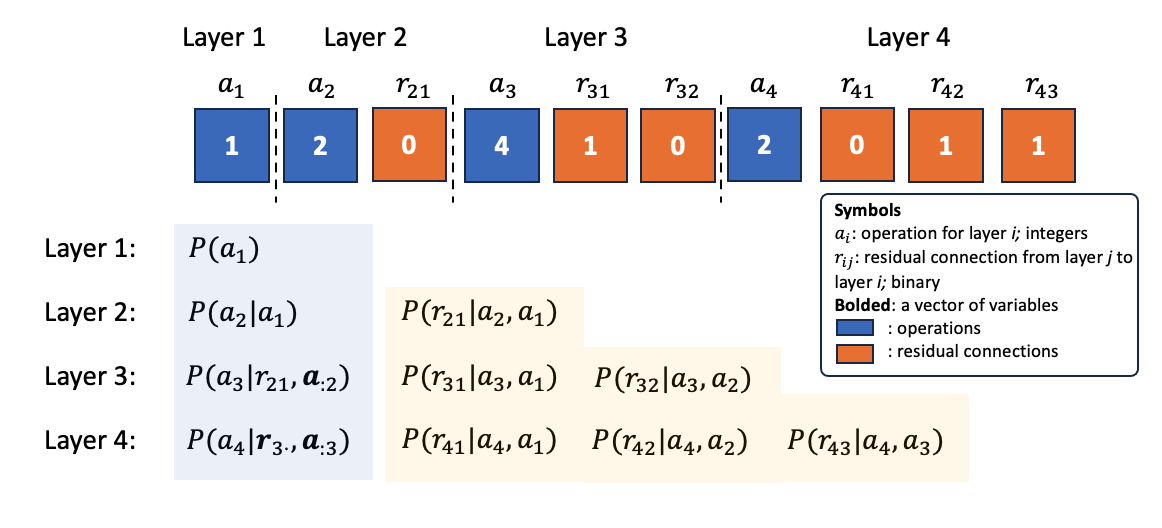

Residual connections are a type of skip connection that directly adds the input of a layer to its output, allowing for another path the data can use to reach latter parts of the NN by skipping layers.

residual connections: [array([0], dtype=int32), array([1, 0], dtype=int32), array([0, 1, 1], dtype=int32)]

is equivalent to

|   |         | Layer 1 | Layer 2 | Layer 3 | 
|---|---------|---------|---------|---------|
|   | Layer 2 | $r_{21}$=0       |                  |                  | 
|   | Layer 3 | $r_{31}$=1       | $r_{32}$=0       |                  | 
|   | Layer 4 | $r_{41}$=0       | $r_{42}$=1       | $r_{43}$=1       | 

In the above example, there are residual connections from layer 1 to 3, from layer 2 to 4, and from layer 3 to 4.

The idea of residual connections is further illustrated in the figure below.

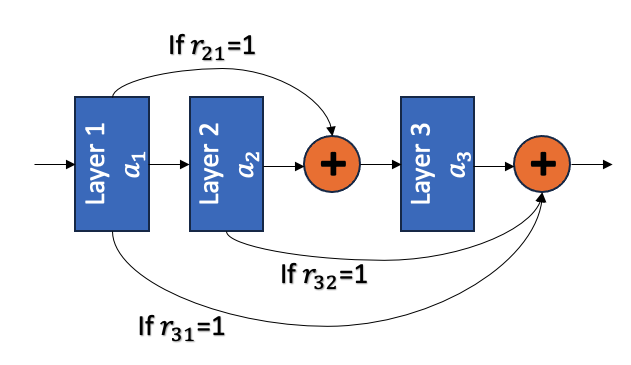

Depending on your use case, you can <u>turn off the residual connections</u>, then the controller will only output the blue tokens representing operations.
```python
controller = amber.architect.controller.RecurrentRLController(model_space=model_space, with_skip_connection=False)
```


## Using a mock reward

We will create a mock reward that scores a substring pattern of `21` in the model architecture, and evaluate if RL can find the optimal solution.

For instance, in `ModelSpace` the five options for each layer is: 0=identity/zero, 1=max-pooling, 2=convolution, 3=average-pooling, 4=dropout. Our `RecurrentRLController` will seek to find `21` pairs, which is `[2=convolution]->[1=max-pooling]` via the mock reward. The optimal 4-layer architecture is `2121`, which represents `conv->maxpool->conv->maxpool`.



<a id='section4'></a>
## Optimizing a black-box function

We will give a minimal example of using `RecurrentRLController` for optimization of a black-box function.

that scores a substring pattern of `21` in the model architecture, and evaluate if RL can find the optimal solution.

For instance, in `ModelSpace` the five options for each layer is: 1=max-pooling, 2=convolution, 3=average-pooling, 4=dropout, 5=identity/zero. Our `RecurrentRLController` will seek to find `21` pairs, which is `[2=convolution]->[1=max-pooling]` via the mock reward. The optimal 4-layer architecture is `2121`, which represents `conv->maxpool->conv->maxpool`.

The function simply counts how many substrings of `21` are in the sampled architecture. 

For instance, `f(arc=1234)=0`, `f(arc=0213)=f(arc=1215)=1`, and `f(arc=2121)=2`

In [6]:
def mock_modeler(arc: list) -> float:
    return ''.join([str(x) for x in arc]).count('21')

# test
mock_modeler([1,2,3,4]), mock_modeler([0,2,1,3]), mock_modeler([1,2,1,5]), mock_modeler([2,1,2,1])

(0, 1, 1, 2)

While this may seem like an easy enough task, it actually **is not**. 

- The model space has $5^4=625$ operation configurations, and there is only $1$ configuration that scores 2, $100$ configurations score 1, with the remaining $524$ configuration score 0. 

- More importantly, the score distribution is not smooth, thus not particularly "gradient-friendly".

- Since the `RecurrentRLController` also samples the residual connections, that further expand the model space by $2^{(1+2+3)}=64$ times, so we have a total of $40,000$ possible models.


As you'll see below, we only need to sample fewer than $250$ to converge to this optimal architecture. 

But, I won't lie to you, it is more likely to converge to the sub-optimal architectures with a score of 1, for the reasons listed above. 

The RL optimization hyperparameters play an essential role here. If you think NAS is a complete hands-free approach, unfortunately it isn't. For example, setting `train_pi_iter=20` will lead to more probable convergence to score 1 architectures because the controller would be trained too hard before it can explore other possibilities. Same applies to a lower temperature e.g. `temperature=1.5`.


In [7]:
%%time
max_iter = 50
rewards = []
for _ in range(max_iter):
    # sample 5 arcs in each iteration
    B = 5
    inner_rewards = []
    for i in range(B):
        arc, prob = controller.sample()
        # only score the ModelVariables, not the residual connections
        ops = controller.decoder.decode(arc)[0]
        reward = mock_modeler(ops)
        controller.store(action=arc, prob=prob, reward=reward)
        inner_rewards.append(reward)
    rewards.append(sum(inner_rewards)/B)
    controller.train()


CPU times: user 3min 12s, sys: 4.16 s, total: 3min 16s
Wall time: 24.7 s


- `controller.decoder.decode()` translates/decodes the sampled architecture into a format that can be used to construct a NN

Text(0, 0.5, 'Reward')

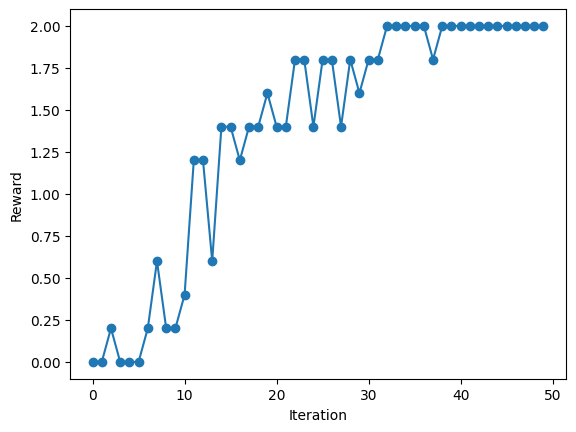

In [8]:
# visualize the rewards over search
fig, ax = plt.subplots()
ax.plot(np.arange(len(rewards)), rewards, marker='o')
ax.set_xlabel('Iteration')
ax.set_ylabel('Reward')


In [9]:
controller.sample()

(array([2, 1, 0, 2, 0, 0, 1, 0, 1, 0], dtype=int32),
 [array([[6.1681043e-05, 8.3854575e-06, 9.9992657e-01, 2.2207450e-08,
          3.3753890e-06]], dtype=float32),
  array([[3.3985284e-06, 9.9982148e-01, 8.9869733e-05, 3.7704840e-06,
          8.1460203e-05]], dtype=float32),
  array([[[9.9998057e-01, 1.9425090e-05]]], dtype=float32),
  array([[4.6525925e-04, 3.4717621e-05, 9.9944288e-01, 5.3445732e-05,
          3.6564545e-06]], dtype=float32),
  array([[[9.9988818e-01, 1.1182314e-04],
          [9.7978938e-01, 2.0210613e-02]]], dtype=float32),
  array([[4.9511942e-07, 9.9999630e-01, 2.8316408e-06, 2.3409119e-07,
          1.5128629e-07]], dtype=float32),
  array([[[0.7480555 , 0.2519445 ],
          [0.3229511 , 0.67704886],
          [0.5160905 , 0.48390955]]], dtype=float32)])

We can see the `RecurrentRLController` successfully learned the optimal architecture `[2,1,2,1]`. Note we only score the Computational Operation part of the architecture, not the Residual Connections.

In [10]:
%load_ext watermark
%watermark -t -u -iv -a FrankZijunZhang -d 

Author: FrankZijunZhang

Last updated: 2024-01-29 15:06:46

numpy     : 1.26.2
amber     : 2.0.0b0
matplotlib: 3.8.2

